In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

base_dir = "/content/drive/MyDrive/chest_xray/chest_xray/chest_xray"
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation and test just need rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory (uses folder names as labels)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5313 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 627 images belonging to 2 classes.


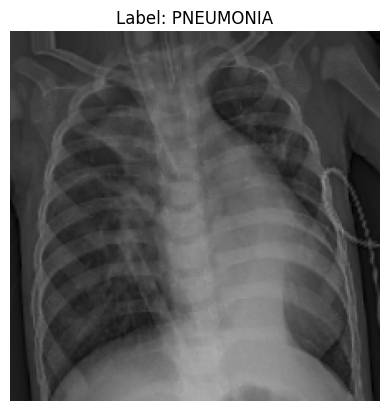

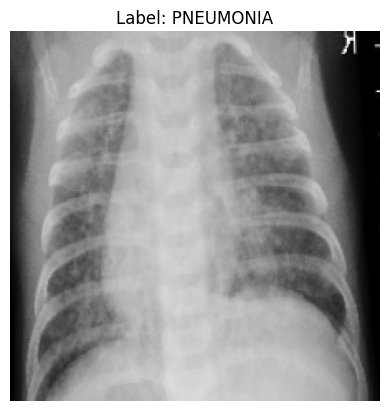

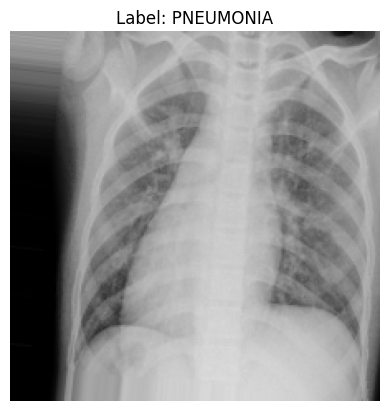

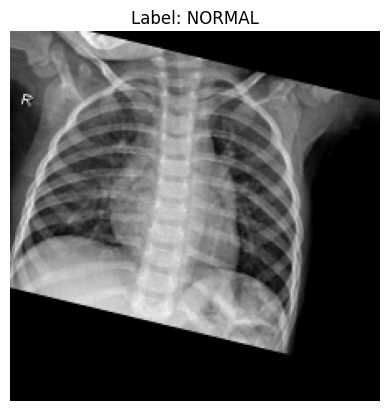

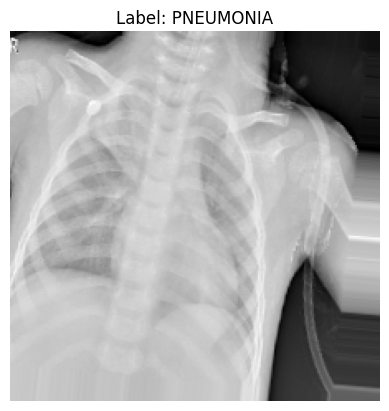

In [3]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)

for i in range(5):
    plt.imshow(x_batch[i])
    plt.title('Label: ' + ('PNEUMONIA' if y_batch[i] else 'NORMAL'))
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 732s 4s/step - accuracy: 0.7827 - loss: 0.5787 - val_accuracy: 0.7500 - val_loss: 0.4495
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 119s 713ms/step - accuracy: 0.8991 - loss: 0.2597 - val_accuracy: 0.6250 - val_loss: 0.8032
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 119s 713ms/step - accuracy: 0.9022 - loss: 0.2492 - val_accuracy: 0.6250 - val_loss: 1.0933
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 121s 723ms/step - accuracy: 0.9024 - loss: 0.2305 - val_accuracy: 0.8125 - val_loss: 0.7471
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 121s 723ms/step - accuracy: 0.9186 - loss: 0.2126 - val_accuracy: 0.8750 - val_loss: 0.4899
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 120s 719ms/step - accuracy: 0.9317 - loss: 0.1788 - val_accuracy: 0.8750 - val_loss: 0.3116
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 116s 695ms/step - accuracy: 0.9273 - loss: 0.1969 - val_accuracy: 0.6250 - val_loss: 0.9231
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 143s 704ms/step - accuracy: 0.9271 - lo

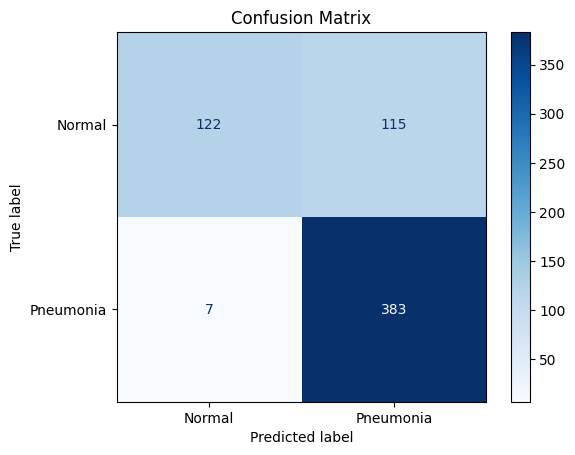

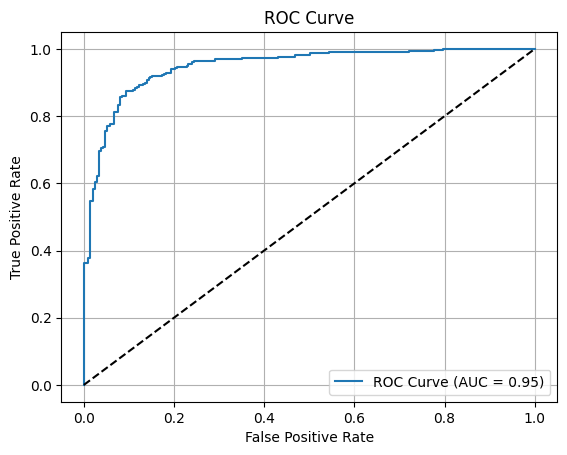

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)

#Accuracy, F1-Score, etc.
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class weights: {0: np.float64(1.9663212435233162), 1: np.float64(0.6704946996466431)}
Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 133s 745ms/step - accuracy: 0.8390 - loss: 0.7515 - val_accuracy: 0.5000 - val_loss: 15.1952 - learning_rate: 1.0000e-04
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 123s 731ms/step - accuracy: 0.9190 - loss: 0.1842 - val_accuracy: 0.5000 - val_loss: 8.5880 - learning_rate: 1.0000e-04
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 141s 727ms/step - accuracy: 0.9202 - loss: 0.1981 - val_accuracy: 0.5000 - val_loss: 3.1132 - learning_rate: 1.0000e-04
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 142s 728ms/step - accuracy: 0.9165 - loss: 0.2096 - val_accuracy: 0.6250 - val_loss: 2.2499 - learning_rate: 1.0000e-04
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 123s 735ms/step - accuracy: 0.9343 - loss: 0.1630 - val_accuracy: 0.8750 - val_loss: 0.2789 - learning_rate: 1.0000e-04
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 122s 729ms/step - accuracy: 0.9385 - loss: 0.1614 - val_accuracy: 0.8750 

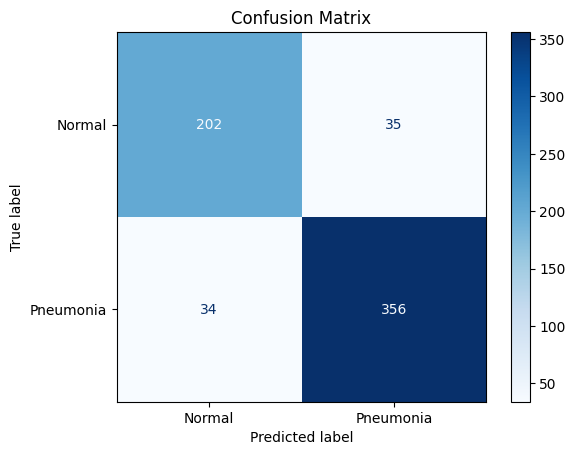

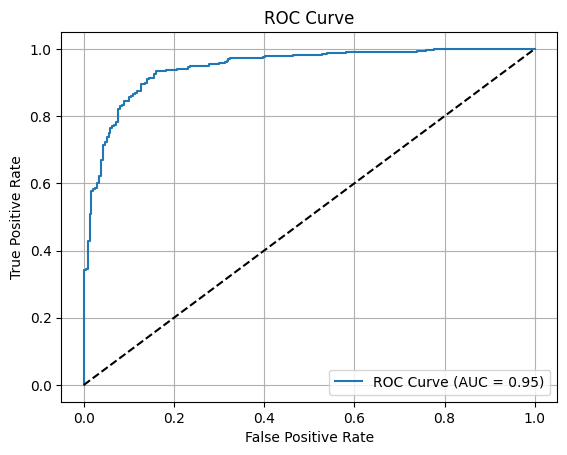

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # reduced from 0.5
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract labels
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_reduce]
)

#Accuracy, F1-Score, etc.
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Classification metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 159s 815ms/step - accuracy: 0.6929 - loss: 0.6099 - val_accuracy: 0.5000 - val_loss: 0.8317 - learning_rate: 1.0000e-04
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 117s 699ms/step - accuracy: 0.7421 - loss: 0.5744 - val_accuracy: 0.5000 - val_loss: 0.8299 - learning_rate: 1.0000e-04
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 142s 699ms/step - accuracy: 0.7455 - loss: 0.5687 - val_accuracy: 0.5000 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 119s 710ms/step - accuracy: 0.7435 - loss: 0.5744 - val_accuracy: 0.5000 - val_loss: 0.8329 - learning_rate: 1.0000e-04
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.7488 - loss: 0.5685
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
167/167 ━━━━━━━━━━━━━━━━━━━━ 118s 707ms/step - accuracy: 0.7488 - loss: 0.5685 - val_accuracy: 0.5000 - val_loss: 0.7951 - learning_rate: 1.0000e

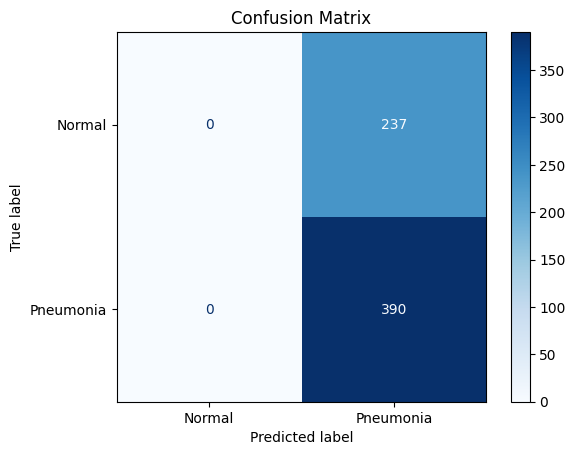

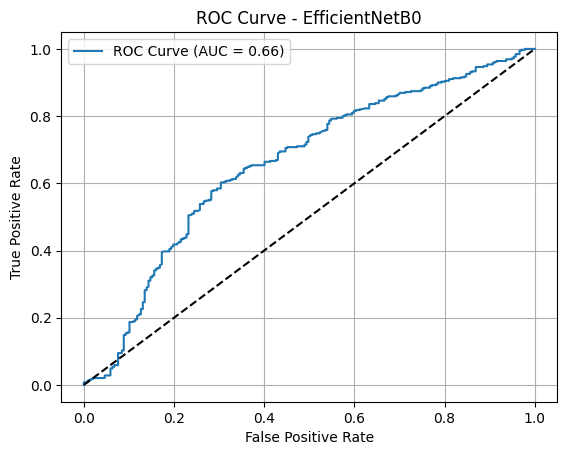

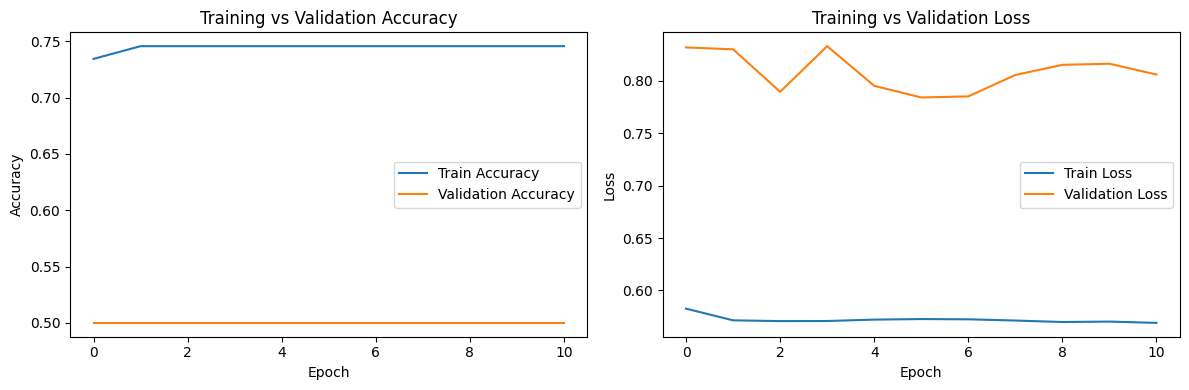

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, lr_reduce]
)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Classification metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNetB0')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 144s 780ms/step - accuracy: 0.7168 - loss: 0.6040 - val_accuracy: 0.5000 - val_loss: 0.7251 - learning_rate: 1.0000e-04
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 126s 722ms/step - accuracy: 0.7380 - loss: 0.5564 - val_accuracy: 0.5000 - val_loss: 0.7322 - learning_rate: 1.0000e-04
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.7497 - loss: 0.5223
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
167/167 ━━━━━━━━━━━━━━━━━━━━ 123s 735ms/step - accuracy: 0.7497 - loss: 0.5223 - val_accuracy: 0.5625 - val_loss: 0.7535 - learning_rate: 1.0000e-04
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 141s 729ms/step - accuracy: 0.7604 - loss: 0.4879 - val_accuracy: 0.5625 - val_loss: 0.7244 - learning_rate: 5.0000e-05
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 141s 723ms/step - accuracy: 0.7715 - loss: 0.4656 - val_accuracy: 0.5625 - val_loss: 0.7814 - learning_rate: 5.0000e-05
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 725m

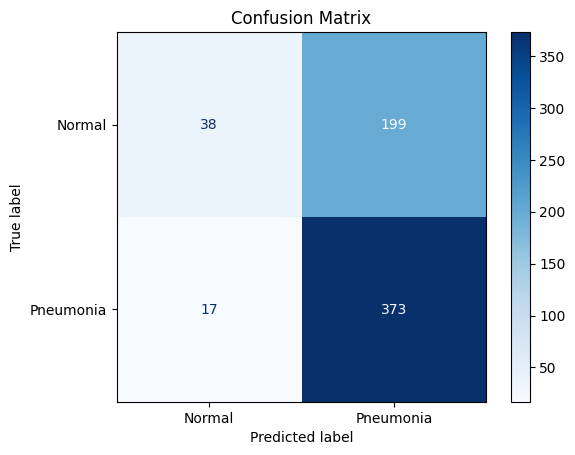

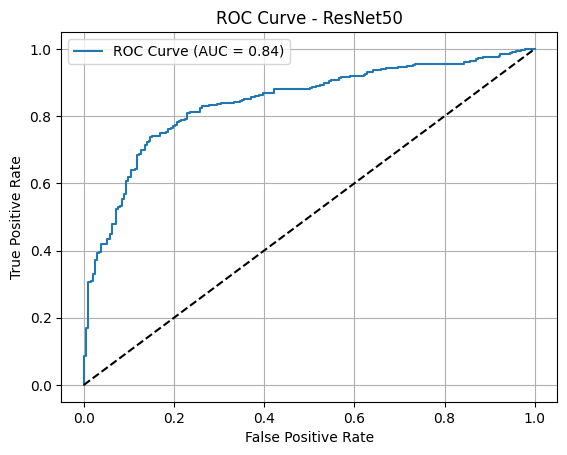

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay # Import accuracy_score here


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # Added a dense layer
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Adjust as needed
    callbacks=[early_stop, lr_reduce]
)


y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
#Classification metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet50')
plt.legend()
plt.grid(True)
plt.show()